In [23]:
!pip list | grep tensor

pytensor                           2.27.1
safetensors                        0.5.3
tensorboard                        2.18.0
tensorboard-data-server            0.7.2
tensorflow                         2.18.0
tensorflow-datasets                4.9.7
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.16.1
tensorflow-probability             0.25.0
tensorflow-text                    2.18.1
tensorstore                        0.1.72


In [24]:
!pip list | grep torch

torch                              2.5.1+cu124
torchaudio                         2.5.1+cu124
torchsummary                       1.5.1
torchvision                        0.20.1+cu124


In [25]:
!nvidia-smi

# It's okay to run this notebook without a GPU!

/bin/bash: line 1: nvidia-smi: command not found


In [26]:
import numpy as np

# Initialize a numpy ndarray with 3 rows, 2 columns
X = np.zeros((3, 2))
X

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [27]:
# By default, ndarrays are float64
X.shape, X.dtype

((3, 2), dtype('float64'))

In [28]:
# We can set values of a whole row
X[0, :] = 1
X

array([[1., 1.],
       [0., 0.],
       [0., 0.]])

In [29]:
# We can set values of a whole column
X[:, 0] = 2
X

array([[2., 1.],
       [2., 0.],
       [2., 0.]])

In [30]:
X = np.array([
  [1, 2],
  [3, 4],
  [5, 6]
])
X

array([[1, 2],
       [3, 4],
       [5, 6]])

In [31]:
x = np.array([10, 20])
print(x)
print(X.shape, x.shape)

# We can add ndarrays of different dimensions
X + x

[10 20]
(3, 2) (2,)


array([[11, 22],
       [13, 24],
       [15, 26]])

In [32]:
X.shape, x.shape

((3, 2), (2,))

In [33]:
# Element-wise multiplication

X * x

array([[ 10,  40],
       [ 30,  80],
       [ 50, 120]])

In [34]:
# Matrix multiplication
# http://matrixmultiplication.xyz/

x = np.array([[10, 20],]).T
result = X @ x  # alternatively, np.dot(X, x)
result

array([[ 50],
       [110],
       [170]])

In [35]:
X = np.random.rand(3, 2)
X

array([[0.89886649, 0.01614   ],
       [0.33404713, 0.13749678],
       [0.86573916, 0.93313337]])

In [36]:
X > 0.5

array([[ True, False],
       [False, False],
       [ True,  True]])

In [37]:
X[X > 0.5] = 1
X

array([[1.        , 0.01614   ],
       [0.33404713, 0.13749678],
       [1.        , 1.        ]])

In [38]:
import matplotlib.pyplot as plt
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

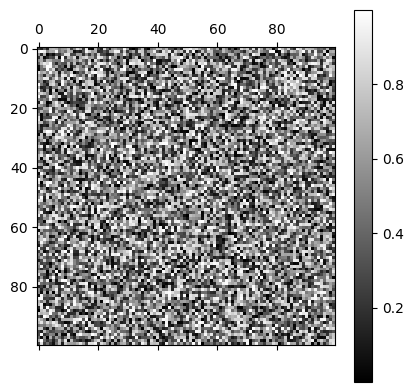

In [39]:
X = np.random.rand(100, 100)
plt.matshow(X)
plt.colorbar()

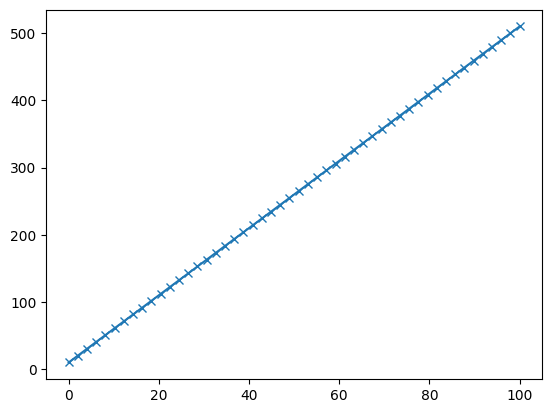

In [40]:
x = np.linspace(0, 100)
y = x * 5 + 10
# y = x * w + b

plt.plot(x, y, 'x-')

x: (50, 1), weights: (1, 1), bias: (1,), y: (50, 1)


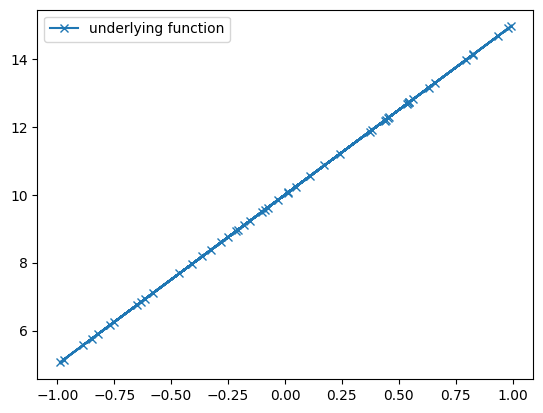

In [41]:
# x is 1-dimensional

n = 50

d = 1
x = np.random.uniform(-1, 1, (n, d))

# y = 5x + 10
weights_true = np.array([[5],])
bias_true = np.array([10])

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plt.plot(x, y_true, marker='x', label='underlying function')
plt.legend()

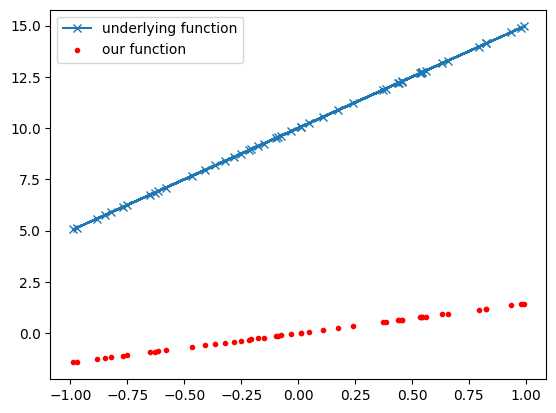

In [42]:
# Let's initialize our predictions

class Linear:
  def __init__(self, input_dim, num_hidden=1):
    # The initialization is important to properly deal with different
    # input sizes (otherwise gradients quickly go to 0).
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)

  def __call__(self, x):
    return x @ self.weights + self.bias

linear = Linear(d)
y_pred = linear(x)
plt.plot(x, y_true, marker='x', label='underlying function')
plt.scatter(x, y_pred, color='r', marker='.', label='our function')
plt.legend()

In [43]:
# How wrong are these initial predictions, exactly?
# It's up to us, and our definition is called the loss function.
# Let's use Mean Squared Error (MSE) as our loss function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_true - y_pred) ** 2).mean()

loss = MSE()
print(f'Our initial loss is {loss(y_pred, y_true)}')

Our initial loss is 105.27832445793702


In [44]:
# Let's use gradient descent to learn the weights and bias that minimizes the loss function.
# For this, we need the gradient of the loss function and the gradients of the linear function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [45]:
# Take one step forward and one step backward to make sure nothing breaks, and that the loss decreases.
loss = MSE()
linear = Linear(d)
y_pred = linear(x)
print(loss(y_pred, y_true))
loss_gradient = loss.backward()
linear.backward(loss_gradient)
linear.update(0.1)
y_pred = linear(x)
print(loss(y_pred, y_true))

115.4146915735397
76.71832332732738


Epoch 0, loss 112.60419607734754
Epoch 5, loss 16.032601786257
Epoch 10, loss 3.759326376512691
Epoch 15, loss 1.4551505667983813
Epoch 20, loss 0.6985859777882939
Epoch 25, loss 0.35471508093355153
Epoch 30, loss 0.18233895178670312
Epoch 35, loss 0.09397288423461495


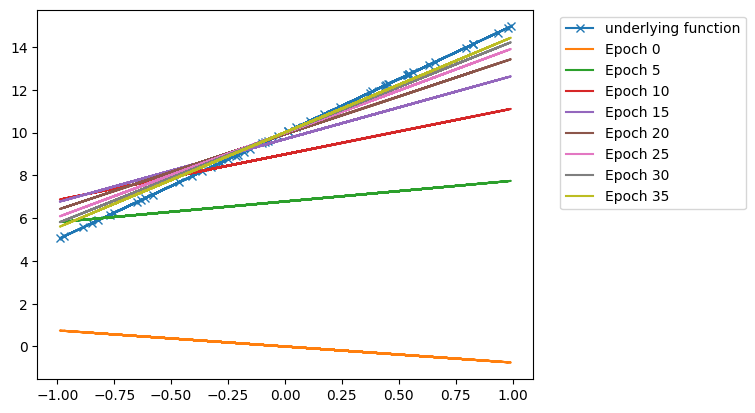

In [46]:
plt.plot(x, y_true, marker='x', label='underlying function')

loss = MSE()
linear = Linear(d)

num_epochs = 40
lr = 0.1

for epoch in range(num_epochs):
  y_pred = linear(x)
  loss_value = loss(y_pred, y_true)

  if epoch % 5 == 0:
    print(f'Epoch {epoch}, loss {loss_value}')
    plt.plot(x, y_pred.squeeze(), label=f'Epoch {epoch}')

  gradient_from_loss = loss.backward()
  linear.backward(gradient_from_loss)
  linear.update(lr)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

(100, 2) (2, 1) (1,)
x: (100, 2), weights: (2, 1), bias: (1,), y: (100, 1)


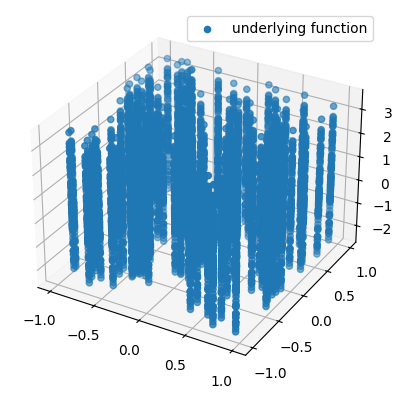

In [47]:
# What about 2-dimensional x?

n = 100
d = 2
x = np.random.uniform(-1, 1, (n, d))

# y = w * x + b
# y = w_0 * x_0 + w_1 * x_1 + b
# y = w@x + b

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x, y_true)

1.116692370112503


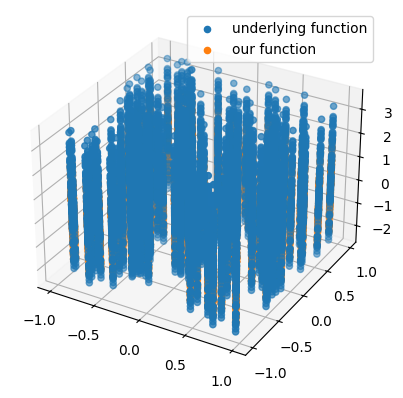

In [48]:
loss = MSE()
linear = Linear(2)
y_pred = linear(x)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true, y_pred)

Epoch 0, loss 1.116692370112503
Epoch 1, loss 0.922289945535688
Epoch 2, loss 0.7675246978664627
Epoch 3, loss 0.642574605652901
Epoch 4, loss 0.5405024185685218
Epoch 5, loss 0.456311651442288
Epoch 6, loss 0.3863290841697541
Epoch 7, loss 0.32779795612662055
Epoch 8, loss 0.2786075700017891
Epoch 9, loss 0.23711158812701144
Epoch 10, loss 0.2020043127239364
Epoch 11, loss 0.1722351385649602
Epoch 12, loss 0.14694835558128122
Epoch 13, loss 0.1254399677598314
Epoch 14, loss 0.10712608297381773
Epoch 15, loss 0.09151929133997987
Epoch 16, loss 0.07821065507648994
Epoch 17, loss 0.06685571593720625
Epoch 18, loss 0.05716343773147331
Epoch 19, loss 0.04888733768515631


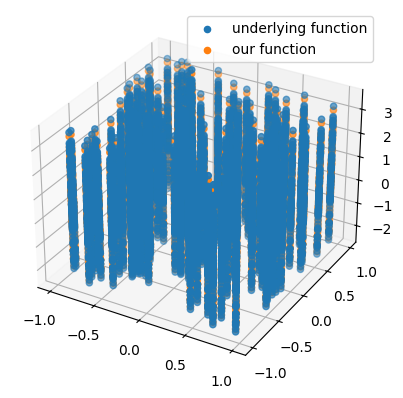

In [49]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=20)
plot_3d(x, y_true, linear(x))

x: (200, 2), weights: (2, 1), bias: (1,), y: (200, 1)


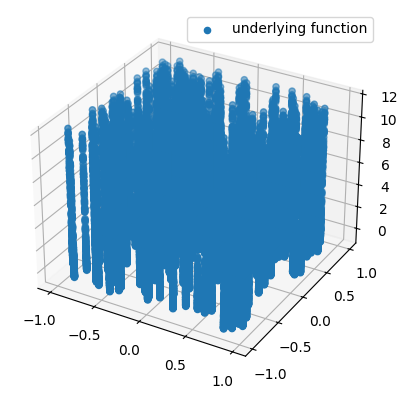

In [50]:
# Make non-linear data

n = 200
d = 2
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[5, 1],]).T
bias_true = np.array([1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true)

Epoch 0, loss 17.943580137396552
Epoch 1, loss 13.822859166501376
Epoch 2, loss 10.986965957247929
Epoch 3, loss 8.999400660692071
Epoch 4, loss 7.577660796764417
Epoch 5, loss 6.538078831075652
Epoch 6, loss 5.76053607233523
Epoch 7, loss 5.165874791949324
Epoch 8, loss 4.701424982352267
Epoch 9, loss 4.331718594926805
Epoch 10, loss 4.032521656583506
Epoch 11, loss 3.7869899074248123
Epoch 12, loss 3.583184771280532
Epoch 13, loss 3.4124618164516365
Epoch 14, loss 3.2684197234672765
Epoch 15, loss 3.146210115802739
Epoch 16, loss 3.042080389143855
Epoch 17, loss 2.953067553661626
Epoch 18, loss 2.8767904407061566
Epoch 19, loss 2.8113063957346536
Epoch 20, loss 2.7550105985472224
Epoch 21, loss 2.7065638564213015
Epoch 22, loss 2.66483966151314
Epoch 23, loss 2.6288844848242183
Epoch 24, loss 2.5978873300922225
Epoch 25, loss 2.571155897953597
Epoch 26, loss 2.5480975730665367
Epoch 27, loss 2.52820401052144
Epoch 28, loss 2.5110384690183967
Epoch 29, loss 2.4962252850113638
Epoch 30

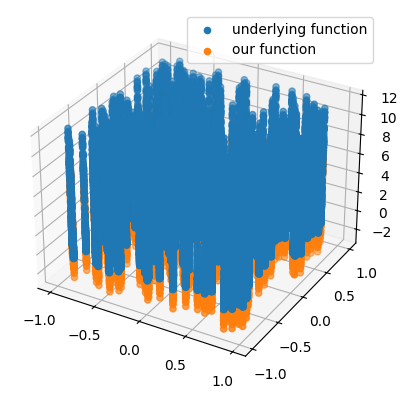

In [51]:
# We can train just fine, but the final loss will remain high, as our linear function is incapable
# of representing the data.

loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, linear(x))

In [52]:
# In order to learn non-linear functions, we need non-linearities in our model.

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output

    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


relu = Relu()
input_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), -1)
print(relu(input_))
print(relu.backward(input_))

[[1. ]
 [0.5]
 [0. ]
 [0. ]
 [0. ]]
[[ 1. ]
 [ 0.5]
 [ 0. ]
 [-0. ]
 [-0. ]]


24.202893726429956


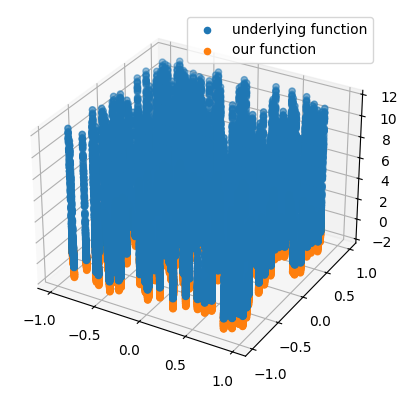

In [53]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)

  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

In [54]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

23.030897705754104
4.646237281140987


Epoch 0, loss 4.646237281140987
Epoch 1, loss 2.6199521420101517
Epoch 2, loss 1.5558507139439
Epoch 3, loss 0.9907207509834582
Epoch 4, loss 0.677812847051367
Epoch 5, loss 0.5014082012030309
Epoch 6, loss 0.4000659772817998
Epoch 7, loss 0.33824143405221446
Epoch 8, loss 0.2982494575008857
Epoch 9, loss 0.27009064428611623
Epoch 10, loss 0.24902615749535265
Epoch 11, loss 0.23286815016421442
Epoch 12, loss 0.22001117612514187
Epoch 13, loss 0.20880986551987185
Epoch 14, loss 0.19896920659694467
Epoch 15, loss 0.19047004386320787
Epoch 16, loss 0.18303644578430597
Epoch 17, loss 0.1764386635858871
Epoch 18, loss 0.17068338172921013
Epoch 19, loss 0.1655460552900986
Epoch 20, loss 0.16075018558243348
Epoch 21, loss 0.15638519242976406
Epoch 22, loss 0.15233824176628769
Epoch 23, loss 0.14865655060316504
Epoch 24, loss 0.14537187312258776
Epoch 25, loss 0.14223118724996286
Epoch 26, loss 0.13931363433758784
Epoch 27, loss 0.13658766476194237
Epoch 28, loss 0.13388456220702885
Epoch 29, 

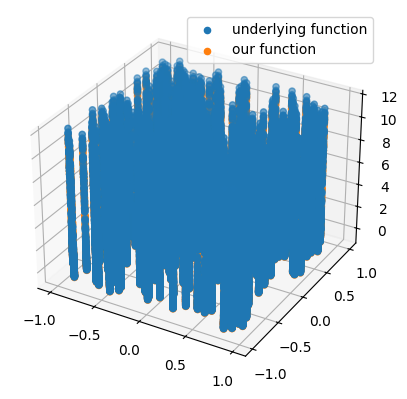

In [55]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x))

In [56]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)

  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(19.9606, grad_fn=<MseLossBackward0>)


In [57]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(19.9606, grad_fn=<MseLossBackward0>)
tensor(15.2840, grad_fn=<MseLossBackward0>)


tensor(15.2840, grad_fn=<MseLossBackward0>)
tensor(12.4264, grad_fn=<MseLossBackward0>)
tensor(9.9405, grad_fn=<MseLossBackward0>)
tensor(7.5590, grad_fn=<MseLossBackward0>)
tensor(5.4611, grad_fn=<MseLossBackward0>)
tensor(3.8578, grad_fn=<MseLossBackward0>)
tensor(2.7070, grad_fn=<MseLossBackward0>)
tensor(1.9431, grad_fn=<MseLossBackward0>)
tensor(1.4718, grad_fn=<MseLossBackward0>)
tensor(1.1886, grad_fn=<MseLossBackward0>)
tensor(1.0113, grad_fn=<MseLossBackward0>)
tensor(0.8957, grad_fn=<MseLossBackward0>)
tensor(0.8097, grad_fn=<MseLossBackward0>)
tensor(0.7365, grad_fn=<MseLossBackward0>)
tensor(0.6748, grad_fn=<MseLossBackward0>)
tensor(0.6211, grad_fn=<MseLossBackward0>)
tensor(0.5753, grad_fn=<MseLossBackward0>)
tensor(0.5348, grad_fn=<MseLossBackward0>)
tensor(0.5003, grad_fn=<MseLossBackward0>)
tensor(0.4686, grad_fn=<MseLossBackward0>)
tensor(0.4404, grad_fn=<MseLossBackward0>)
tensor(0.4150, grad_fn=<MseLossBackward0>)
tensor(0.3922, grad_fn=<MseLossBackward0>)
tensor(0.

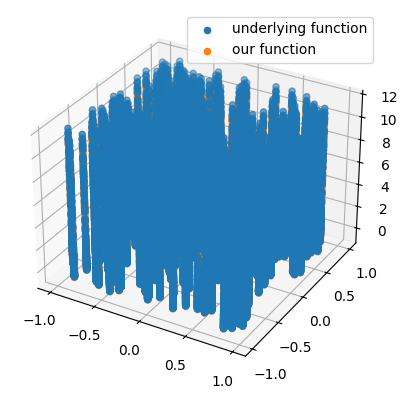

In [58]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ regression (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3247  
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2670 
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7069 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4539 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3179 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2512 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2509 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2647 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2999 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3268 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


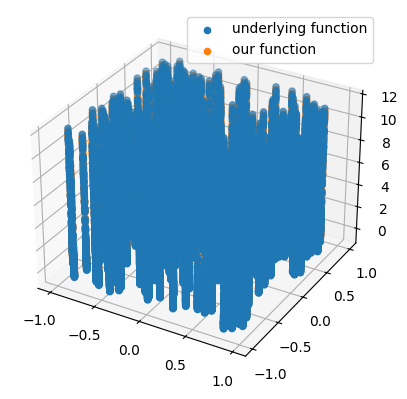

In [59]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))